# Nuevo código

In [1]:
# Bibliotecas a usar
import glob
import re
import copy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2 as cv
from scipy.integrate import quad
from scipy.special import beta

In [2]:
paths = glob.glob("../extdata/all-mias/*.pgm")
paths[0:5]

['../extdata/all-mias/mdb035.pgm',
 '../extdata/all-mias/mdb103.pgm',
 '../extdata/all-mias/mdb075.pgm',
 '../extdata/all-mias/mdb050.pgm',
 '../extdata/all-mias/mdb169.pgm']

In [3]:
class MIAS:
    def __init__(self, path):
        self.path = path
        self.ref = re.search("mdb[0-9]{3}", path).group()
        img = cv.imread(path, cv.IMREAD_REDUCED_GRAYSCALE_4)
        self.img = cv.medianBlur(img, 3)

    def plot(self):
        plt.imshow(self.img, cmap='gray')
        plt.show()

    def __repr__(self):
        self.plot()
        return self.ref

    def __print__(self):
        return self.__repr__()

    def __getitem__(self, index):
        return self.img[index]

    def __copy__(self):
        cp = MIAS(self.path)
        cp.img = self.img
        return cp

    def copy(self):
        return copy.copy(self)

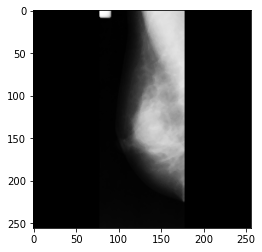

mdb035


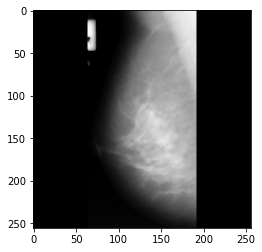

mdb103


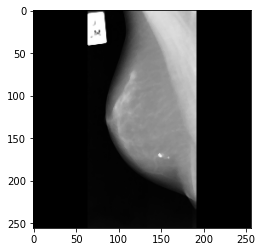

mdb075


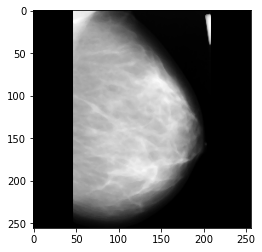

mdb050


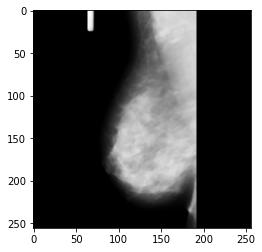

mdb169


In [50]:
for path in paths[0:5]:
    print(MIAS(path))

# Tarea 1

In [4]:
class CleanBg():
    def __init__(self, mdb, ksize=(5, 5)):
        self.mdb = mdb
        # Creación del kernel compuesto por un disco de radio 2
        self.kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, ksize)
        self.kernel[[1, 1, 3, 3], [0, 4, 0, 4]] = 0

    # Obtener del umbral a partir del valor del nivel de gris en la imagen
    def T(self):
        hist = cv.calcHist([self.mdb.img], [0], None, histSize=[256],
                           ranges=(0, 256), accumulate=False)
        H_n = hist.astype(int).ravel()
        T = 0.2 * np.sum(np.arange(0, 256) * H_n) / np.sum(H_n)
        return np.uint8(T)

    # Binarizar la imagen
    def bin(self):
        img_bin = self.mdb.img.copy()
        T = self.T()
        with np.nditer(img_bin, op_flags=['readwrite']) as it:
            for x in it:
                x[...] = 1 if x >= T else 0
        return cv.morphologyEx(img_bin, cv.MORPH_OPEN, self.kernel)

    # Obtener una imagen binarizada a partir de otra mostrando una región
    # específica seleccionada
    def get_bg_region(self):
        # Ejecutar un análisis de componentes conectadas para extraer los
        # objetos de la imagen
        img_bin = self.bin()
        num_labs, labs, stats, centroids = \
            cv.connectedComponentsWithStats(img_bin, connectivity=4,
                                            ltype=cv.CV_16U)
        # Índices de todos los objetos encontrados
        objects = np.arange(num_labs)
        # Extraer el objeto más grande (con área mayor)
        max_obj = np.argmax(stats[1::, 4]) + 1
        # Extraer la imagen binarizada del fondo
        img_region = labs.copy().astype(np.uint8)
        # Extraer el fondo, incluyendo los objetos más pequeños
        bg_obj = np.ma.array(objects, mask=False)
        bg_obj.mask[max_obj] = True
        bg_obj = bg_obj.compressed()
        with np.nditer(img_region, op_flags=['readwrite']) as it:
            for x in it:
                x[...] = 1 if x in bg_obj else 0
        return img_region

    # Limpiar el fondo de la imagen
    def clean_bg(self):
        img_bin = self.bin()
        # Obtener la región que no pertenece a la región del busto
        bg_region = self.get_bg_region()
        # Modificar las intensidades que no pertenecen a la región del busto
        img_clean = self.mdb.img.copy()
        with np.nditer(bg_region, flags=['multi_index']) as it:
            for x in it:
                if x:
                    img_clean[it.multi_index] = 0
        mdb_clean = self.mdb.copy()
        mdb_clean.img = img_clean
        return mdb_clean

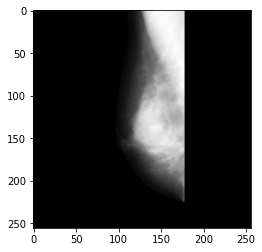

mdb035


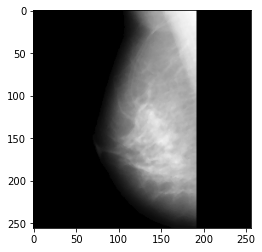

mdb103


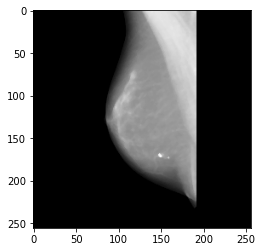

mdb075


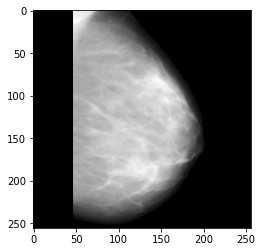

mdb050


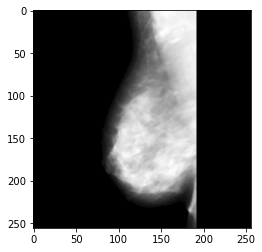

mdb169


In [51]:
for path in paths[0:5]:
    test = MIAS(path)
    print(CleanBg(test).clean_bg())

# Tarea 2

In [34]:
class CleanPM():
    def __init__(self, mdb, ksize=(5, 5)):
        self.mdb = mdb.copy()
        # Creación del kernel compuesto por un disco de radio 2
        self.kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, ksize)
        self.kernel[[1, 1, 3, 3], [0, 4, 0, 4]] = 0

    def get_pm_region(self, fg_bin):
        num_labs, labs, stats, centroids = \
            cv.connectedComponentsWithStats(fg_bin, connectivity=4,
                                                ltype=cv.CV_16U)
        pm_region = self.mdb.img.copy()
        try:
            pm_ind = np.argmin(stats[1::, 1]) + 1
        except:
            return pm_region, False
        with np.nditer(labs, flags=['multi_index']) as it:
            for x in it:
                if x != pm_ind:
                    pm_region[it.multi_index] = 0
        return pm_region, True

    def clean_pm(self):
        last_thresh = -np.inf
        thresh, img_bin = cv.threshold(self.mdb.img, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
        while last_thresh != thresh:
            img_bin = cv.morphologyEx(img_bin, cv.MORPH_OPEN, self.kernel)
            # Calcular el promedio del primer plano
            fg = np.ma.array(self.mdb.img, mask=False)
            fg.mask = np.where(img_bin == 255, False, True)
            mu_1 = fg.mean()
            # Filtrar la región del primer plano usando el promedio
            fg_bin = np.zeros(self.mdb.img.shape, self.mdb.img.dtype)
            with np.nditer(self.mdb.img, flags=['multi_index']) as it:
                for x in it:
                    if x > mu_1:
                        fg[it.multi_index] = x
                        fg_bin[it.multi_index] = 255
            # Filtrar la región del músculo pectoral
            pm_region, pm_exists = self.get_pm_region(fg_bin)
            if not(pm_exists):
                break
            # Actualizar los umbrales
            last_thresh = thresh
            thresh, img_bin = cv.threshold(pm_region, 0, 255,
                                           cv.THRESH_BINARY + cv.THRESH_OTSU)
        # Modificar las intensidades que pertenecen a la región del músculo pectoral
        img_clean = self.mdb.img.copy()
        with np.nditer(img_bin, flags=['multi_index']) as it:
            for x in it:
                if x == 255:
                    img_clean[it.multi_index] = 0
        mdb_clean = self.mdb.copy()
        mdb_clean.img = img_clean
        return mdb_clean

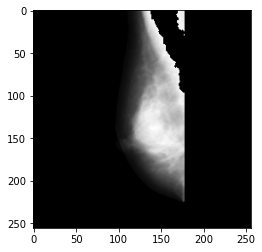

mdb035


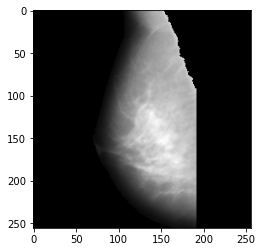

mdb103


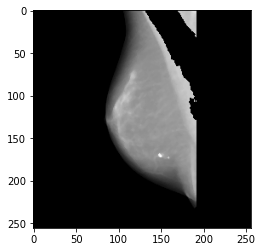

mdb075


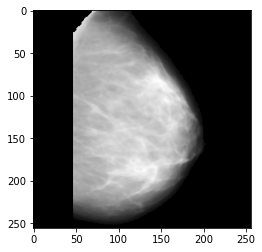

mdb050


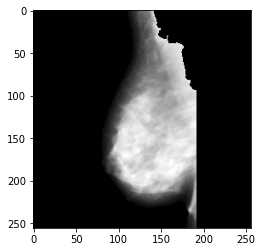

mdb169


In [52]:
for path in paths[0:5]:
    test = MIAS(path)
    test = CleanBg(test).clean_bg()
    print(CleanPM(test).clean_pm())

 # Ejecutar Tarea 1 y 2

In [35]:
class CleanMIAS():
    def __init__(self, path):
        self.mdb = MIAS(path)

    def clean_img(self):
        mdb_clean = CleanBg(self.mdb).clean_bg()
        return CleanPM(mdb_clean).clean_pm()

In [37]:
mdb_clean = []

for i, path in enumerate(paths):
    if i % 10 == 0:
        print(i)
    mdb_clean.append(CleanMIAS(path).clean_img())

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320


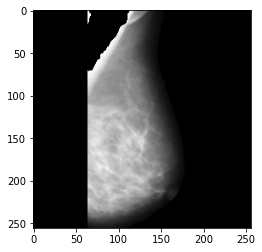

mdb094

In [45]:
mdb_clean[46]

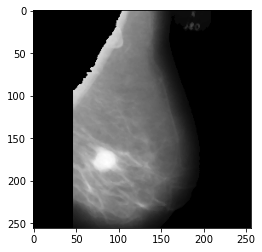

mdb028

In [44]:
mdb_clean[50]

# Tarea 3

In [414]:
with open('../extdata/all-mias/info.csv') as file:
    info = pd.read_csv(file)
    
info

,ref,bg_tissue,abnorm,severity,x,y,approx_radius
0,mdb001,G,CIRC,B,535.0,425.0,197.0
1,mdb002,G,CIRC,B,522.0,280.0,69.0
2,mdb003,D,NORM,NaN,NaN,NaN,NaN
3,mdb004,D,NORM,NaN,NaN,NaN,NaN
4,mdb005,F,CIRC,B,477.0,133.0,30.0
...,...,...,...,...,...,...,...
325,mdb318,D,NORM,NaN,NaN,NaN,NaN
326,mdb319,D,NORM,NaN,NaN,NaN,NaN
327,mdb320,D,NORM,NaN,NaN,NaN,NaN
328,mdb321,D,NORM,NaN,NaN,NaN,NaN


In [ ]:
bg_tissue = info[['ref', 'bg_tissue']].drop_duplicates(ignore_index=True)

In [ ]:
imgs_clean = []

for mdb in mdb_clean:
    imgs_clean.append(mdb.img)

In [ ]:
X = np.reshape(imgs_clean_2, (322, 256*256))
y = bg_tissue['bg_tissue'].values.reshape(-1)
print(X.shape, y.shape)

# Código antiguo

In [ ]:
# Bibliotecas a usar
import os
import re
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.pipeline import make_pipeline

from scipy.integrate import quad
from scipy.special import beta
from scipy.interpolate import CubicSpline

In [ ]:
# Obtener del umbral a partir del valor del nivel de gris en la imagen
def c(img):
    hist = cv.calcHist([img], [0], None, histSize=[256], ranges=(0, 256), accumulate=False).ravel()
    return local_minimum(H_n)

# Binarizar la imagen
def binarization(img):
    return np.where(img >= c(img), 1, 0).astype(np.uint8)

In [ ]:
local_minimum(np.array([23, 1, 6, 5, 0]))

In [ ]:
?np.argmin

In [ ]:
img_p = imgs_clean[41].copy().astype(float)
img_p[0][46]

In [ ]:
img_p = imgs_clean[1].copy().astype(float)
img_p *= 1/float(255)
img_p = np.float32(img_p)

# Hacemos una copia de la imagen limpia 51
a = 5
b = 4

def BDF(t):
    return (t ** (a - 1)) * ((1 - t) ** (b - 1))

with np.nditer(img_p, op_flags=['readwrite']) as it:
    for x in it:
        x[...], _ = quad(BDF, 0, x) / beta(a, b)
        
plt.imshow(img_p, cmap='gray')

In [ ]:
m = np.count_nonzero(img_p)

mu_k = (1 / m) * np.sum(img_p)
mu_k

In [ ]:
edge = np.zeros(img_p.shape)
coords = []

for i, row in enumerate(img_p):
    bina = np.where(np.logical_and(row < mu_k, row != 0), 0, 1)
    first_pix = np.argmin(bina) if np.any(bina == 0) else np.inf
    if first_pix < np.inf:
        coord = (i, first_pix)
        coords.append(coord)
        edge[coord] = 1.0
    
plt.imshow(edge, cmap='gray')

In [ ]:
CubicSpline(edge[])